### Dependency 
VineCopula : for computing copula

In [87]:
library(VineCopula)

## Functions for twostage_H and twostageS
* pi_0 : A function for estimating null proportion based on Storey's method. 
* twostage_H : A function for 2-stage (H)
* twostage_S : A function for 2-stage (S)

### pi_0
Input
* p(vector) : p values, all elements should be in [0,1]
* lambda(scalar) : the p values which are larger than labmda would be consiered to be generated from null hypotheses.
Output
* null proporion (scalar): estimated null proportion by Storey's method.

In [88]:
pi_0 = function(p, lambda = 0.5) 1/(1-lambda)*sum(p>lambda)/length(p)

### twostage_H

Input
* u1(vector) : auxiliary p values, all elements shoud be in [0,1].
* u2(vector) : primary p values, all elements should be in [0,1] and length(u2) == length(u1)
* cop(copula) : BiCop object in VineCopula package.
* alpha(scalar) : the significance level. If not specified, the default is 0.05
* gamma1(scalar) : the threshold for u1. it must be in [0,1]. If not specified, it automatically find gamma1 which rejects most.

Output
* pval_H(vector) : p values computed by Type H.
* rejected(vector) : rejected or not

In [89]:
twostage_H = function(u1,u2,cop,alpha = 0.05, gamma1 = NA){
    n = length(u1)
    if(is.na(gamma1)){
        gammaseq = seq(0.5, 1, 0.001)
        nrej = sapply(gammaseq, function(x){
            pv = BiCopCDF(rep(x, n), u2, obj = cop)
            pval_H = ifelse(u1>x, u1, pv)
            p0hat = min(pi_0(pval_H, 0.5),1)
            rejH = p0hat*n*pval_H/rank(pval_H) < alpha
            return(sum(rejH))
            })
        gamma1 = gammaseq[which.max(nrej)]
        }
    pv = BiCopCDF(rep(gamma1,n), u2, obj = cop)
    pval_H = ifelse(u1>gamma1, u1, pv)
    p0hat = min(pi_0(pval_H, 0.5),1)
    false_H = rank(pval_H)
    rejected = (p0hat*n*pval_H/false_H<alpha)

    return(list(pval_H = pval_H, rejected = rejected))
}

### twostage_S

Input
* u1(vector) : auxiliary p values, all elements shoud be in [0,1].
* u2(vector) : primary p values, all elements should be in [0,1] and length(u2) == length(u1)
* cop(copula) : BiCop object in VineCopula package.
* alpha(scalar) : the significance level. If not specified, the default is 0.05

Output
* pval_S(vector) : p values computed by Type S.
* rejected(vector) : rejected or not

In [90]:
twostage_S = function(u1,u2,cop, alpha = 0.05){
  n = length(u1)
  pval_S = BiCopHfunc1(u1, u2, obj = cop)
  p0hat = min(pi_0(pval_S, 0.5),1)
  rejected = (p0hat*n*pval_S/rank(pval_S)<alpha)
  
  return(list(pval_S = pval_S, rejected = rejected))
}

## Examples

### Example 1 : correctly specified copula

In [91]:
set.seed(1)

In [92]:
gencop = BiCop(23, tau = -0.4) # We will generate random samples from Clayton Copula

In [93]:
r = BiCopSim(1000, obj = gencop)

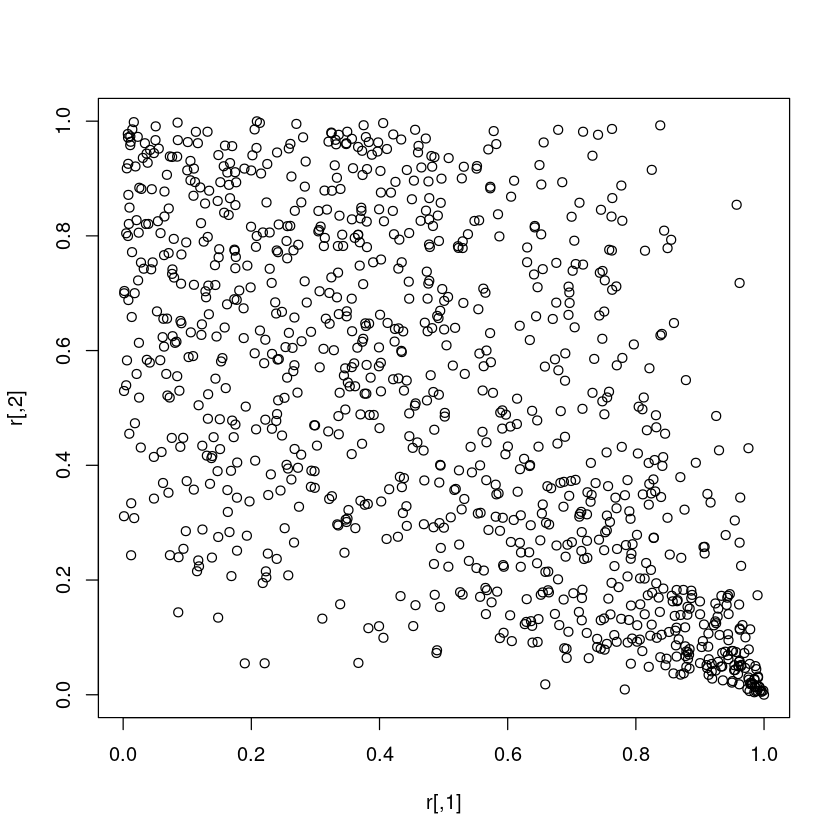

In [94]:
plot(r)

In [95]:
cop = BiCopEst(r[,1], r[,2], family = 23) # estimated copula

In [96]:
testH = twostage_H(r[,1], r[,2], cop)

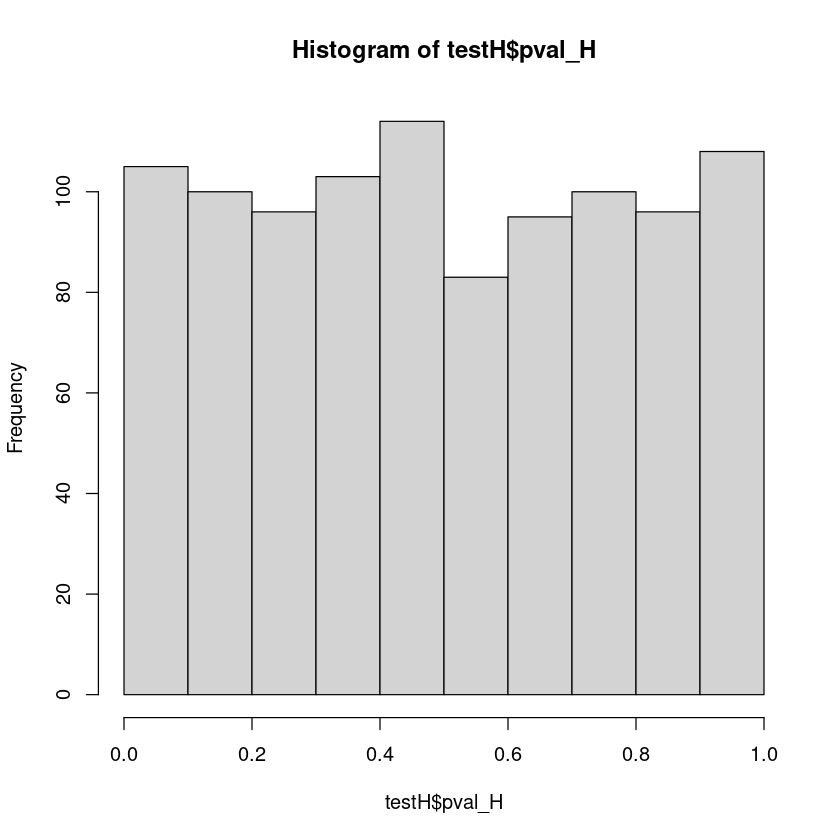

In [97]:
hist(testH$pval_H) ##uniformly distributed since all samples are generated from null

In [98]:
testS = twostage_S(r[,1], r[,2], cop)

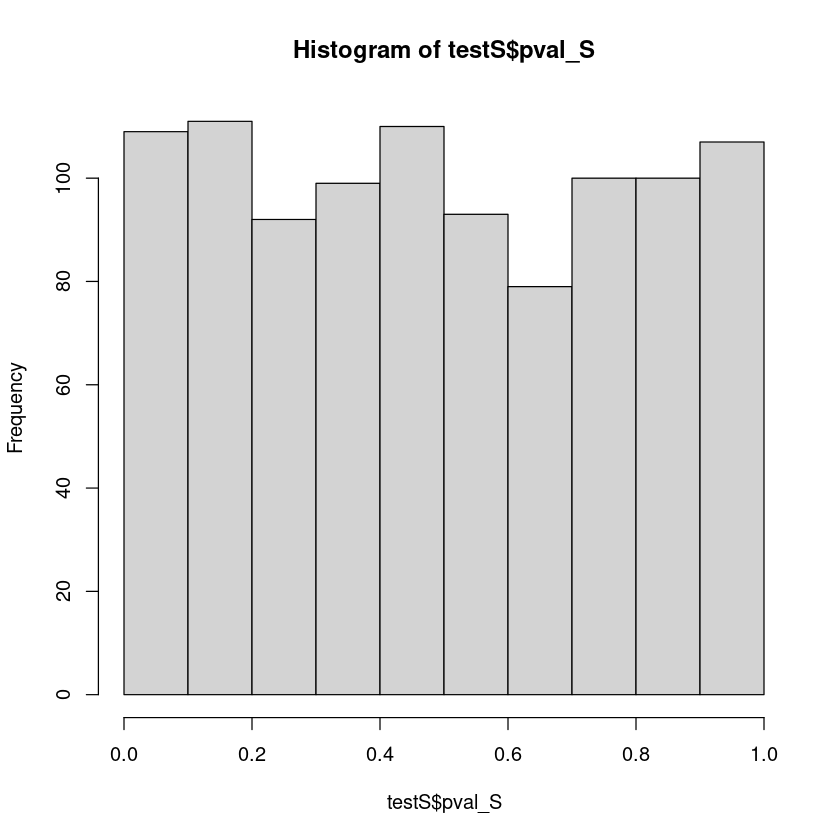

In [99]:
hist(testS$pval_S) ##uniformly distributed since all samples are generated from null

### Example 2 : misspecified copula

In [100]:
set.seed(1)

In [101]:
gencop = BiCop(23, tau = -0.4) # We will generate random samples from Clayton Copula

In [102]:
r = BiCopSim(1000, obj = gencop)

In [103]:
coptest = BiCopEstList(r[,1], r[,2], c(23,24,36,38,39), rotations = F) ## we will compare Clayton(23), Gumbel(24), Joe(36), BB6(38) and BB7(39) 

In [104]:
coptest$summary ## Joe copula is chosen

family,logLik,AIC,BIC
<dbl>,<dbl>,<dbl>,<dbl>
23,322.00,-642.01,-637.10
24,149.44,-296.89,-291.98
36,322.33,-642.65,-637.75
38,322.33,-640.65,-630.84
39,322.43,-640.86,-631.05


In [105]:
cop = BiCopEst(r[,1], r[,2], family = 36) # generated by clayton(23), but we will estimated with Joe(36)

In [70]:
testH2 = twostage_H(r[,1], r[,2], cop)

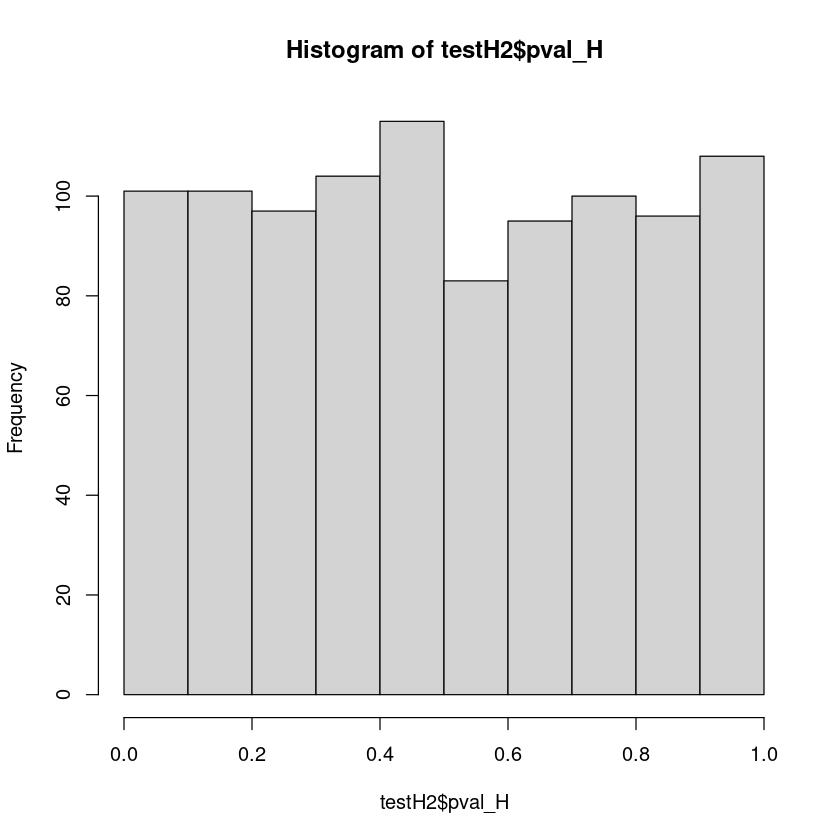

In [71]:
hist(testH2$pval_H) ##Still, it seems uniformly distributed (not exact)

In [72]:
testS2 = twostage_S(r[,1], r[,2], cop)

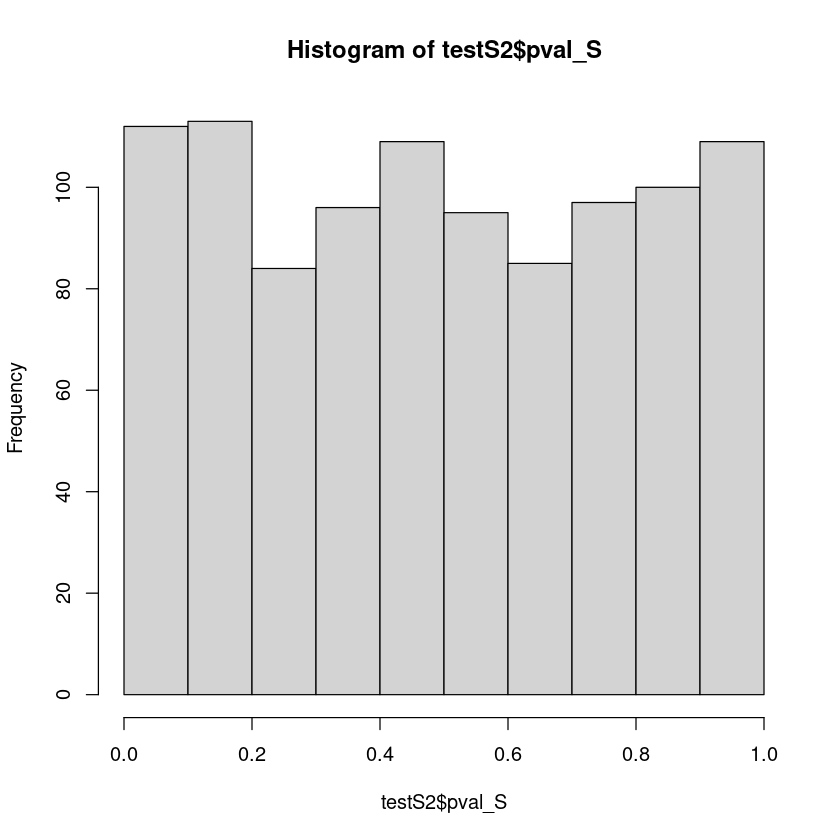

In [86]:
hist(testS2$pval_S) ##Still,it seems uniformly distributed (not exact)